In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import openai
#openai.api_key = os.environ['OPENAI_API_KEY']

openai.api_base = os.environ.get("OPENAI_API_BASE", "https://api.openai.com/v1")
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from models.validation_likelihood_tuning import get_autotuned_predictions_data
import logging
import pickle


def plot_preds(train, test, pred_dict, model_name, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()



gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

model_hypers = {
    #'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    #'LLMTime GPT-3': {'model': 'text-davinci-003', **gpt3_hypers},
    #'PromptCast GPT-3': {'model': 'text-davinci-003', **promptcast_hypers},
    'ARIMA': arima_hypers,
    
}

model_predict_fns = {

    #'LLMTime GPT-3': get_llmtime_predictions_data,
    #'LLMTime GPT-3.5': get_llmtime_predictions_data,
    'LLMTime GPT-4': get_llmtime_predictions_data,
    #'PromptCast GPT-3': get_promptcast_predictions_data,
    'ARIMA': get_arima_predictions_data,
}

model_names = list(model_predict_fns.keys())



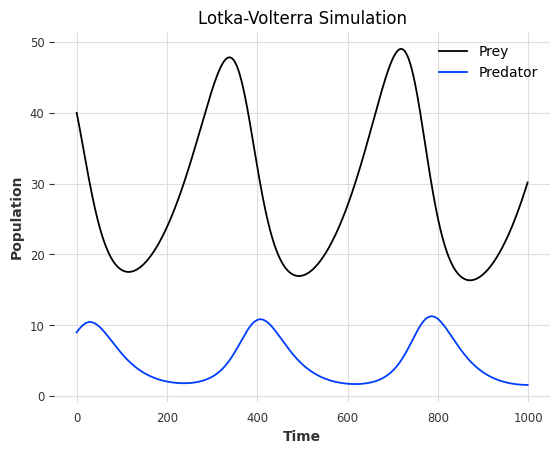

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def lotka_volterra(a, b, c, d, x0, y0, timesteps):
    """
    Simulate the Lotka-Volterra equations.

    Parameters:
    a: float, prey growth rate
    b: float, predation rate
    c: float, predator death rate
    d: float, predator reproduction rate
    x0: float, initial prey population
    y0: float, initial predator population
    timesteps: int, number of time steps

    Returns:
    x_values: numpy array, prey population over time
    y_values: numpy array, predator population over time
    """

    def dx_dt(x, y):
        return a * x - b * x * y

    def dy_dt(x, y):
        return -c * y + d * x * y

    dt = 0.01  # Time step size
    x_values = np.zeros(timesteps)
    y_values = np.zeros(timesteps)

    x_values[0] = x0
    y_values[0] = y0

    for i in range(1, timesteps):
        x = x_values[i - 1]
        y = y_values[i - 1]
        x_values[i] = x + dt * dx_dt(x, y)
        y_values[i] = y + dt * dy_dt(x, y)

    return x_values, y_values

# Example usage:
a = 1
b = 0.2
c = 3
d = 0.1
x0 = 40
y0 = 9
timesteps = 1000

x_values, y_values = lotka_volterra(a, b, c, d, x0, y0, timesteps)

plt.plot(x_values, label='Prey')
plt.plot(y_values, label='Predator')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.title('Lotka-Volterra Simulation')
plt.show()


In [19]:
def concatenate_arrays(x_values, y_values, n):
    """
    Concatenate x_values and y_values into a single array, alternating between n points from each.

    Parameters:
    x_values: numpy array, first set of values
    y_values: numpy array, second set of values
    n: int, number of points to take at a time from each array

    Returns:
    concatenated_array: numpy array, concatenated array
    """

    concatenated_array = np.empty((0,))
    for i in range(0, len(x_values), n):
        concatenated_array = np.concatenate((concatenated_array, x_values[i:i+n], y_values[i:i+n]))

    return concatenated_array

# Example usage:
concatenated_array = concatenate_arrays(x_values, y_values, 10)
print(concatenated_array)


[40.         39.68       39.3554176  ...  1.58353777  1.58317141
  1.58312715]


In [20]:
train_multi = concatenated_array[0:50]
test_multi = concatenated_array[50:100]

pred_dict_arima_multi = get_autotuned_predictions_data(train_multi, test_multi, hypers, 10, model_predict_fns['ARIMA'], verbose=False, parallel=False)



Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [6]:
model_hypers['LLMTime GPT-4']

{'model': 'gpt-4',
 'alpha': 0.3,
 'basic': True,
 'temp': 1.0,
 'top_p': 0.8,
 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}

In [8]:
model_hypers['ARIMA']

{'p': [12, 30], 'd': [1, 2], 'q': [0]}

In [9]:
hypers = list(grid_iter(model_hypers['LLMTime GPT-4']))
hypers

[defaultdict(dict,
             {'model': 'gpt-4',
              'alpha': 0.3,
              'basic': True,
              'temp': 1.0,
              'top_p': 0.8,
              'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')})]

In [12]:
pred_dict_arima_multi 

{'NLL/D': 15.328272133597775,
 'samples':           50         51         52         53         54         55  \
 0  25.023157  25.391586  24.717092  21.095797  16.403467  13.517864   
 1  25.023157  23.264692  22.925835  22.417311  21.847124  18.646450   
 2  25.023157  26.497317  27.423120  31.715073  30.562352  31.158733   
 3  25.023157  25.766864  25.101268  24.093243  22.296717  20.087522   
 4  25.023157  21.697724  20.243865  13.946275  11.151239   9.364319   
 5  25.023157  26.936564  29.593448  30.731119  32.438143  33.685771   
 6  25.023157  26.105536  27.113098  26.171901  26.229784  24.774603   
 7  25.023157  25.763977  25.302178  23.450867  20.323867  14.965249   
 8  25.023157  27.200147  27.772582  28.718018  29.516934  29.097925   
 9  25.023157  25.812916  27.018166  26.508749  28.241172  24.795574   
 
           56         57         58         59  ...         90         91  \
 0   7.555564   4.346629  -2.572358  -6.346735  ...  22.758608  24.666007   
 1  17.1095

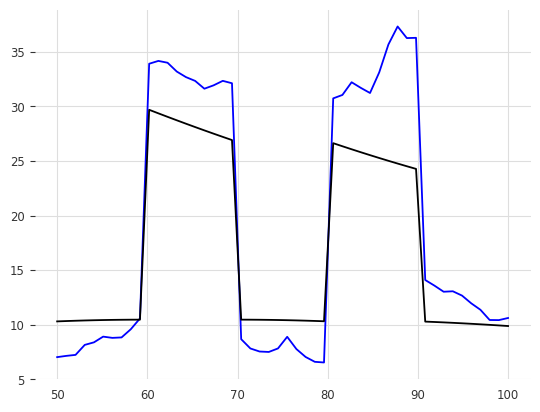

In [21]:
plt.plot(np.linspace(50,100,50),pred_dict_arima_multi['median'],'b') 
plt.plot(np.linspace(50,100,50),test_multi,'k')

In [22]:
pred_dict_gpt_multi = get_autotuned_predictions_data(train_multi, test_multi, hypers, 10, model_predict_fns['LLMTime GPT-4'], verbose=False, parallel=False)



Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.23s/it]

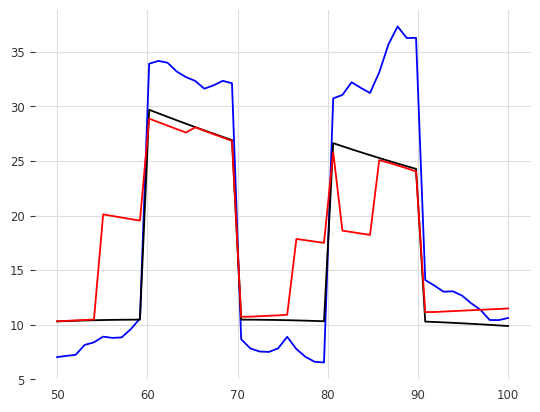

In [23]:
plt.plot(np.linspace(50,100,50),pred_dict_arima_multi['median'],'b') 
plt.plot(np.linspace(50,100,50),test_multi,'k')
plt.plot(np.linspace(50,100,50),pred_dict_gpt_multi['median'],'r') 

### overlay the points end to end

In [25]:
def divide_array(concatenated_array, n):
    """
    Divide concatenated_array into two parts, each containing n points.

    Parameters:
    concatenated_array: numpy array, concatenated array
    n: int, number of points in each part

    Returns:
    x_values: numpy array, first set of values
    y_values: numpy array, second set of values
    """

    x_values = concatenated_array[::2*n]
    y_values = concatenated_array[n::2*n]

    return x_values, y_values

# Example usage:
x_values_divided_gpt, y_values_divided_gpt = divide_array(pred_dict_gpt_multi['median'], 10)

x_values_divided_arima, y_values_divided_arima = divide_array(pred_dict_arima_multi['median'], 10)
x_values_test, y_values_test =  divide_array(test_multi, 10)



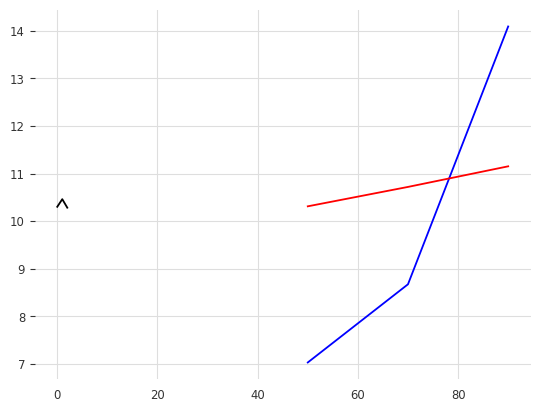

In [28]:
plt.plot(x_values_divided_arima,'b') 
plt.plot(x_values_test,'k')
plt.plot(x_values_divided_gpt,'r') 